# Five Years of the LCDS

### By: github.com\crahal

### Last Modified: 10/10/2024

Lets first load the absolutely essential libraries we need to grab and analyse the data:

In [1]:
import os # help with pathing
import pandas as pd # worlds greatest data wrangling tool
from get_data import get_all_openalex_dois # custom module to get all returns from OpenAlex (DOIs
from get_data import get_first_display_name
from get_data import make_concepts, make_auth_df, make_network
from figure_helpers import plot_figure1, plot_concepts, make_network_figure
fig_path = os.path.join('..', 'figures')

Lets then use the file (also on GitHub i.e. [here](https://github.com/OxfordDemSci/LCDS_5yr_Report/blob/main/data/raw/publications.xlsx)]) which contains information -- importantly on all LCDS DOIs -- to push through the OpenAlex API. This is Bradley's 'publications.xlsx' for 2023/2024, merged with DOIs from previous years.

In [2]:
path_to_raw = os.path.join(os.getcwd(), '..', 'data', 'raw', 'publications.xlsx')
raw_df = pd.read_excel(path_to_raw)

Now we've read in our raw dataset, lets define a path where the scientometric returns are going to live:

In [3]:
path_to_scientometrics = os.path.join(os.getcwd(), '..', 'data', 'scientometrics')

And then feed this path into a custom function which uses the DOIs in the publications.xlsx to grab meta data about those publications:

In [4]:
df = get_all_openalex_dois(raw_df[raw_df['DOI'].notnull()]['DOI'].str.lower().str.strip().to_list(),
                           os.path.join(path_to_scientometrics, 'OpenAlex_Returns_LCDS_5yr.csv'))

We have 322 DOIs to query from OpenAlex


100%|█████████████████████████████████████████| 322/322 [04:04<00:00,  1.31it/s]


Cool! We've got data on 322 DOIs from OpenAlex. That return lives at `./data/scientometrics/OpenAlex_Returns_LCDS_5yr.csv`, i.e. [here](https://github.com/OxfordDemSci/LCDS_5yr_Report/blob/main/data/scientometrics/OpenAlex_Returns_LCDS_5yr.csv) and is publically available because of OpenAlex's great approach to permissive licensing. Thanks guys!

What percent of our papers are in the top 1% of the OpenAlex distribution (for papers that have citation counts that arent NaN)?

In [5]:
df['citation_normalized_percentile.is_in_top_1_percent'].value_counts()

citation_normalized_percentile.is_in_top_1_percent
False    177
True     123
Name: count, dtype: int64

Cool! Something like 123/(177+123)*100 = 41%. What about the top 10%?

In [6]:
df['citation_normalized_percentile.is_in_top_10_percent'].value_counts()

citation_normalized_percentile.is_in_top_10_percent
True     164
False    136
Name: count, dtype: int64

Even better; 123/(177+123) = 54.66%!

Now, lets look at the major outlets which the LCDS publishes in. Note, this also gets saved out to `./data/scientometrics/journal_counts.csv`:

In [7]:
df['first_display_name'] = df['locations'].apply(get_first_display_name)
df[['first_display_name']].value_counts().to_csv(os.path.join(path_to_scientometrics, 'journal_counts.csv'))
df[['first_display_name']].value_counts()[0:15]

first_display_name                             
Demographic Research                               18
Proceedings of the National Academy of Sciences    15
Population Studies                                 11
medRxiv (Cold Spring Harbor Laboratory)            10
Demography                                          9
International Journal of Epidemiology               8
European Sociological Review                        6
PLoS ONE                                            6
Nature Human Behaviour                              6
bioRxiv (Cold Spring Harbor Laboratory)             6
UCL Discovery (University College London)           5
BMJ Open                                            5
Population and Development Review                   5
SSM - Population Health                             4
Scientific Reports                                  4
Name: count, dtype: int64

OK! Lets now package this and other things into a figure. The data that goes into this figure also gets saved to various files at `./data/scientometrics/`. This figure contains -- in the top left -- citation counts and article types (outter level classication) over time, in the top right THIS THING IS GOING TO CHANGE, in the bottom left is the frequency of publicaiton in each journal, in the bottom right is a more granular classification of the subjects that the team publishes in. The top left is based on the "primary_topic.field.display_name". The bottom right is based on the `primary_topic.field.display_name' variable.

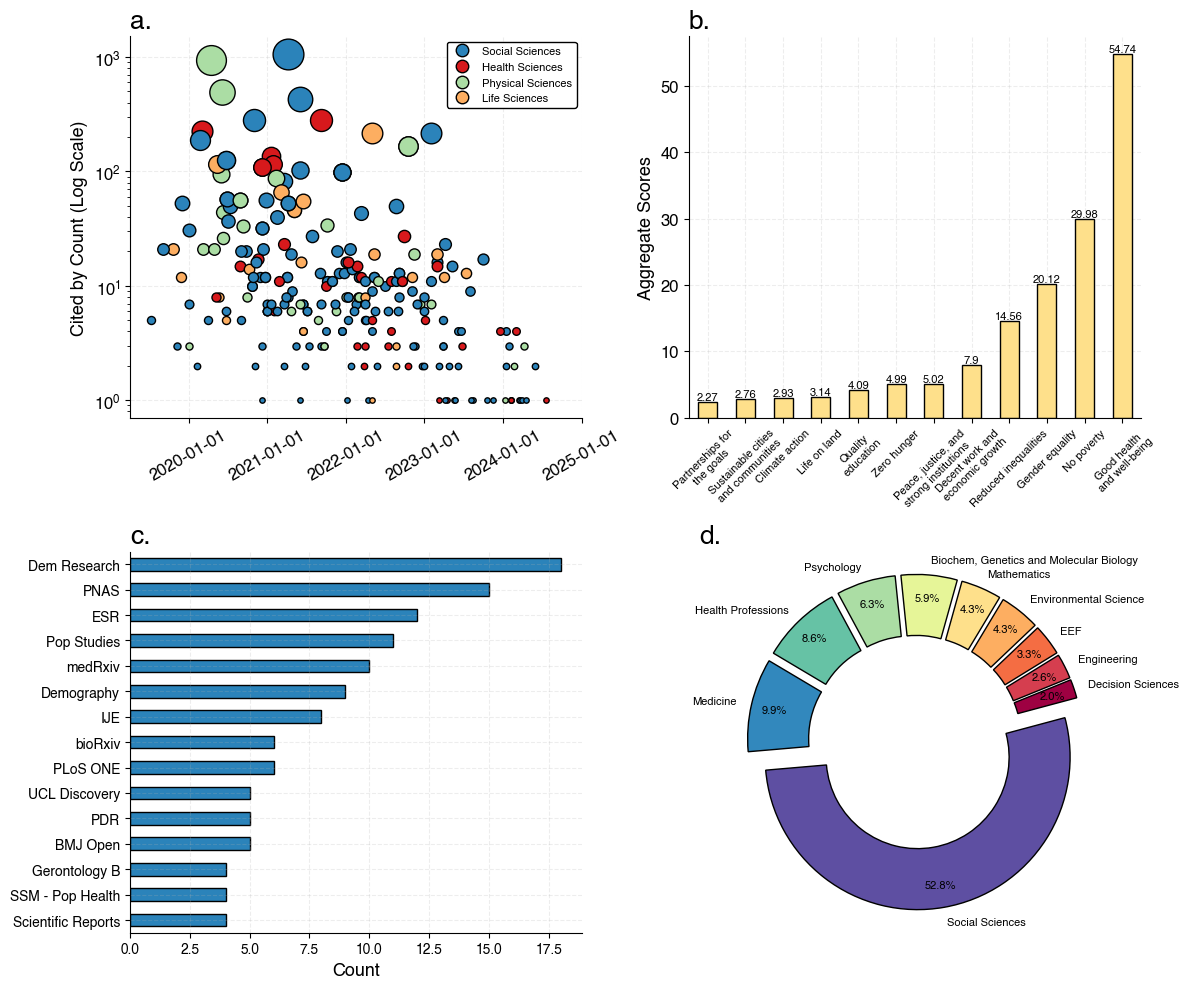

In [8]:
plot_figure1(df, path_to_scientometrics, fig_path)

Now, lets make the concepts; Were going to be using level 1-3 concepts from OpenAlex. Learn more about them [[here]](https://docs.openalex.org/api-entities/concepts). These three concepts get saved to `./data/scientometrics/level_one_concepts.csv` for levels one, two, and three.

In [9]:
df_level_1, df_level_2, df_level_3 = make_concepts(df, path_to_scientometrics)

Then, plot these concepts. This, like all of the other figures, gets saved out to `./data/figures/`.

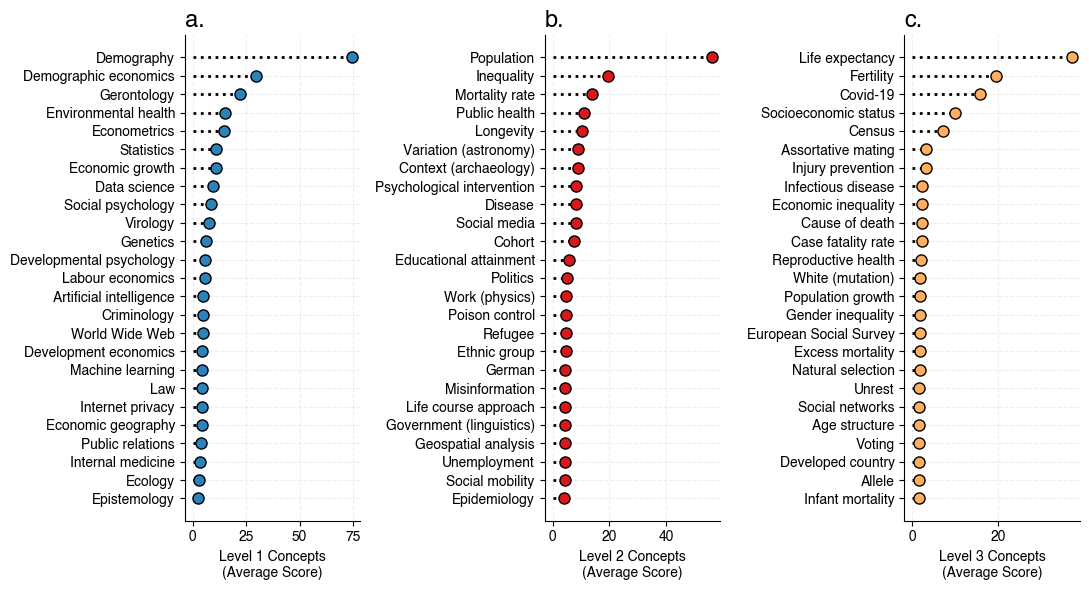

In [10]:
plot_concepts(df_level_1, df_level_2, df_level_3, fig_path)

In [11]:
auth_df = make_auth_df(df, path_to_scientometrics)

authorname
Jose Manuel Aburto    51
Melinda Mills         51
Jennifer B. Dowd      43
Ridhi Kashyap         28
Andrea M. Tilstra     20
Valentina Rotondi     18
Charles Rahal         14
John Ermisch          13
Per Engzell           13
Mark D. Verhagen      13
Name: count, dtype: int64


In [12]:
import requests
from tqdm import tqdm
import os
import pandas as pd
import matplotlib as mpl
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from scipy import sparse as sp

mpl.rcParams['font.family'] = 'Helvetica'

def make_network(auth_df, norm=None):
    temp_auth = auth_df.drop_duplicates(subset=['doi', 'authorid'])
    temp_auth = temp_auth[temp_auth['doi'].notnull()]
    author_papers = temp_auth[temp_auth['authorid'].notnull()]
    int_p_id = dict(enumerate(list(author_papers['doi'].unique())))
    int_a_id = dict(enumerate(list(author_papers['authorid'].unique())))
    a_int_id = {authorId: intVal for intVal, authorId in int_a_id.items()}
    p_int_id = {paperId: intVal for intVal, paperId in int_p_id.items()}  # Fixed variable name
    author_paper_tuples = list(zip(author_papers['authorid'], author_papers['doi']))
    author_paper_tuples = [(a_int_id[t[0]], p_int_id[t[1]]) for t in author_paper_tuples]

    n_rows = len(a_int_id)  # Number of unique authors
    n_cols = len(p_int_id)  # Number of unique papers
    rows, cols = zip(*author_paper_tuples)  # Unpack the row (author) and column (paper) indices
    AP = sp.csc_matrix((np.ones(len(author_paper_tuples)), (rows, cols)), shape=(n_rows, n_cols))

    AA = AP.dot(AP.T)
    AA = np.array(AA - np.diag(AA.diagonal()))
    G = nx.from_numpy_array(AA, parallel_edges=True)
    centrality = nx.degree_centrality(G)
    norm = plt.Normalize(vmin=0, vmax=0.35)
    cmap = mpl.colormaps.get_cmap('Spectral_r')
    node_color = [cmap(norm(centrality[n])) for n in G.nodes()]
    return G, node_color, norm



G, node_color, norm = make_network(auth_df)
mills_list = auth_df[auth_df['authorname'].str.contains('Mills')]['doi'].tolist()
G_mills, node_color_mills, norm_mills = make_network(auth_df[auth_df['doi'].isin(mills_list)], norm=norm)
dowd_list = auth_df[auth_df['authorname'].str.contains('Dowd')]['doi'].tolist()
G_dowd, node_color_dowd, norm_dowd = make_network(auth_df[auth_df['doi'].isin(dowd_list)], norm=norm)

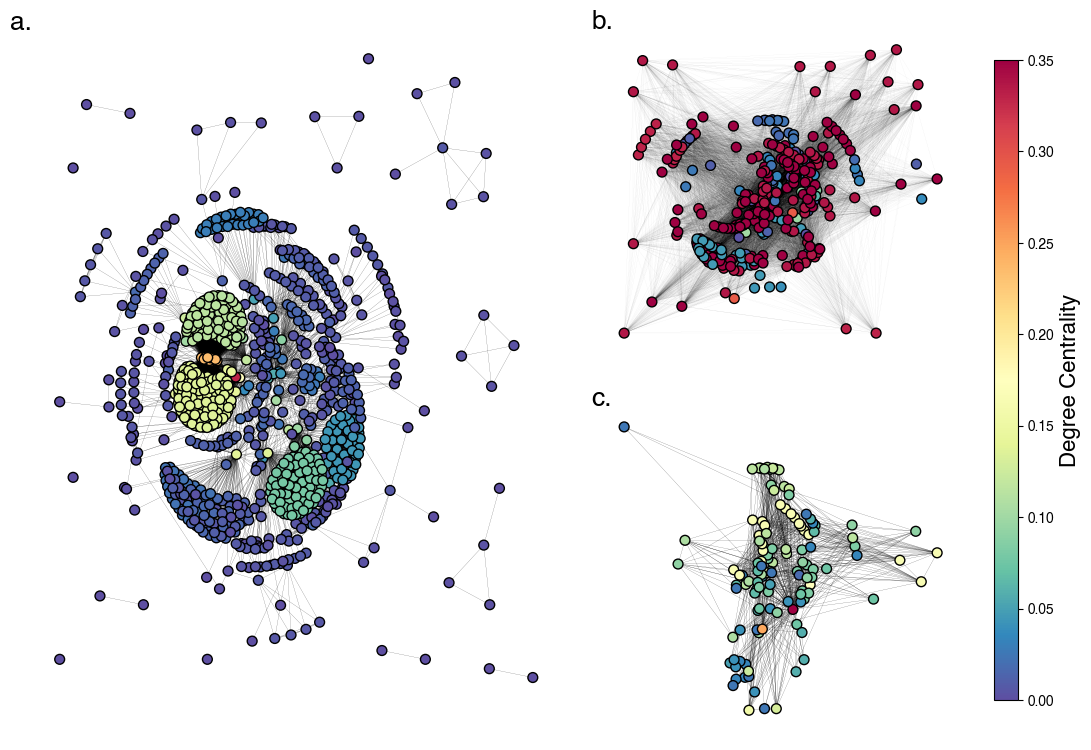

In [13]:
make_network_figure(fig_path, G, node_color, norm, G_mills, node_color_mills, G_dowd, node_color_dowd)